# Блок 1. Формулировка задачи

**Датасет:** Iris (Hugging Face: `iris`)  
https://huggingface.co/datasets/scikit-learn/iris

**Описание:**
- 150 записей о цветах ириса.  
- Признаки: длина чаши, ширина чаши, длина лепестка, ширина лепестка
- Целевая переменная: вид цветка Species (`Iris-setosa`, `	
Iris-versicolor`, `Iris-virginica`).  

---

## Задача
По длинам чаши и лепестка предсказать вид цветка.

- **Тип задачи:** классификация (мультикласс).  
- **Метрики:** Accuracy, F1-macro, Confusion Matrix.  

---

## Пользовательский сценарий
- Составная часть пайплайна для проверки качества продукции закупаемой цветочным дистрибьютором.    

---

## Цель практики
- Отработать весь ML-цикл на простом примере.  
- Попробовать несколько моделей (логистическая регрессия, дерево решений, случайный лес, SVM).


# Блок 2. Загрузка и первичный осмотр

In [2]:
!pip install -q datasets seaborn pandas matplotlib scikit-learn numpy

from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context="talk", style="whitegrid")

In [3]:
dataset_dict = load_dataset("scikit-learn/iris")

print("Сплиты и количество объектов:", {split_name: len(dataset_dict[split_name]) for split_name in dataset_dict})

print("\nСхема признаков (HF features):")
print(dataset_dict["train"].features)

# -----------------------------
# ШАГ 2. Перевести train-часть в pandas для удобного EDA.
# -----------------------------
iris_dataframe = dataset_dict["train"].to_pandas()

# Проверим размер и список колонок.
print("\nРазмер таблицы (строки, колонки):", iris_dataframe.shape)
print("Колонки:", sorted(iris_dataframe.columns.tolist()))


Generating train split: 100%|██████████| 150/150 [00:00<00:00, 8932.41 examples/s]

Сплиты и количество объектов: {'train': 150}

Схема признаков (HF features):
{'Id': Value('int64'), 'SepalLengthCm': Value('float64'), 'SepalWidthCm': Value('float64'), 'PetalLengthCm': Value('float64'), 'PetalWidthCm': Value('float64'), 'Species': Value('string')}

Размер таблицы (строки, колонки): (150, 6)
Колонки: ['Id', 'PetalLengthCm', 'PetalWidthCm', 'SepalLengthCm', 'SepalWidthCm', 'Species']


In [5]:
# -----------------------------
# ШАГ 3. Сформировать список «ключевых» колонок ПРОЗРАЧНО.
all_columns_from_data = set(iris_dataframe.columns)

target_column = "Species"
candidate_feature_columns = [
    "PetalLengthCm",
    "PetalWidthCm",
    "SepalLengthCm",
    "SepalWidthCm",
]


expected_columns = set([target_column] + candidate_feature_columns)

missing_columns = expected_columns - all_columns_from_data
if missing_columns:
    raise ValueError(
        "В датасете не хватает ожидаемых колонок: "
        f"{sorted(missing_columns)}.\n"
        "Проверьте версию датасета/сплита или скорректируйте список признаков."
    )

feature_columns = candidate_feature_columns[:]   # копия на всякий случай
print("\nЦелевая переменная:", target_column)
print("Признаки (feature_columns):", feature_columns)


iris_dataframe.head()



Целевая переменная: Species
Признаки (feature_columns): ['PetalLengthCm', 'PetalWidthCm', 'SepalLengthCm', 'SepalWidthCm']


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


# Блок 3. Первичная диагностика данных (EDA light)

Перед тем как строить модель, важно понять, что у нас за данные и в каком они состоянии.  

---

### 1. Проверка пропусков
- В данных встречаются **NaN** — это значит, что какое-то значение не было измерено.  
- Это не баг, а нормальная ситуация в реальных исследованиях.  
- Модели scikit-learn напрямую работать с NaN не умеют → придётся потом решать, как их обрабатывать.




### 2. Типы признаков
- **Числовые признаки**: размеры тела (клюв, крыло, масса).  
- **Категориальные признаки**: остров и пол.  
- Зачем разделять: числовые обрабатываются через масштабирование/статистики, категориальные — через кодирование.  
- Пример абсурда: нельзя взять логарифм от пола пингвина.

---

### 3. Базовая статистика
- Проверяем минимумы, максимумы, средние значения.  
- Если у пингвина масса 30 000 грамм — это подозрительно, стоит проверить.  
- Смотрим, нет ли выбросов и странных значений.

---

### 4. Баланс классов (species)
- Если один вид встречается гораздо чаще других → простая модель может «читерить», всегда предсказывать его и получать высокий accuracy.  
- Поэтому нам нужны более адекватные метрики, например F1 или ROC-AUC.

---

### 5. Визуализация
- Scatterplot (например, длина vs глубина клюва) показывает, можно ли вообще разделять виды по признакам.  
- На графиках видно, что виды пингвинов реально образуют группы.  
- Это хороший знак: задача классификации имеет смысл.


In [ ]:
print("Количество пропусков в каждой колонке:\n")
print(iris_dataframe.isna().sum())

Количество пропусков в каждой колонке:

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64


In [9]:
numeric_columns = iris_dataframe.select_dtypes(include="number").columns.tolist()
# Id вроде как не нужен
numeric_columns = [col for col in numeric_columns if col != "Id"]
print("\nЧисловые признаки:", numeric_columns)

stats_table = (
    iris_dataframe[numeric_columns]
    .describe()
    .T[["mean", "std", "min", "max"]]
    .round(2)
)

print("\nОписание числовых признаков:\n")
stats_table



Числовые признаки: ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

Описание числовых признаков:



,mean,std,min,max
SepalLengthCm,5.84,0.83,4.3,7.9
SepalWidthCm,3.05,0.43,2.0,4.4
PetalLengthCm,3.76,1.76,1.0,6.9
PetalWidthCm,1.20,0.76,0.1,2.5



Распределение классов (Species):

Species
Iris-setosa        0.333
Iris-versicolor    0.333
Iris-virginica     0.333
Name: proportion, dtype: float64


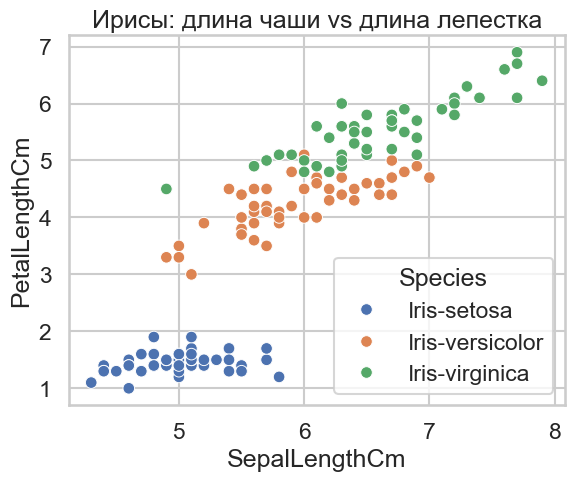

In [ ]:
print("\nРаспределение классов (Species):\n")
print(iris_dataframe["Species"].value_counts(normalize=True).round(3))

sns.scatterplot(
    data=iris_dataframe,
    x="SepalLengthCm",
    y="PetalLengthCm",
    hue="Species", # покрасим точки, чтобы понимать какой класс
    s=70   # размер точек
)
plt.title("Ирисы: длина чаши vs длина лепестка")
plt.show()


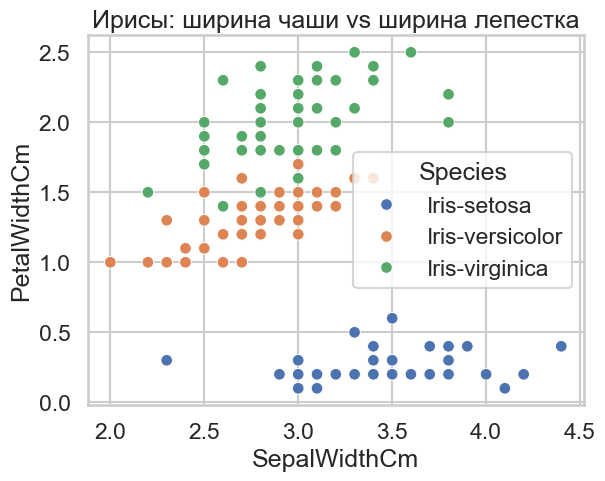

In [ ]:
sns.scatterplot(
    data=iris_dataframe,
    x="SepalWidthCm",
    y="PetalWidthCm",
    hue="Species",
    s=70
)
plt.title("Ирисы: ширина чаши vs ширина лепестка")
plt.show()

# Что видно:
# - Виды образуют группы (кластеры).
# - Например, у Iris-setosa длина чаши короткая и глубокая, а у Iris-versicolor длинная и узкая.
# - Это значит, что признаки реально помогают разделять классы → задача ML осмысленна.

# Блок 4. Подготовка данных

Перед тем как строить модель, нужно привести данные в порядок.  
Если пропустить этот этап, модель может упасть с ошибкой или научиться на «кривых» данных.

---

### 1. Пропуски (NaN) 
- Машинное обучение напрямую не умеет работать с NaN → надо что-то с ними делать.  
- Возможные стратегии:
  - **Удалить строки** с пропусками (просто, но мы теряем данные).  
  - **Заполнить значения**:
    - для числовых признаков: среднее или медиана;  
    - для категориальных: самое частое значение (мода).  
- Для обучения мы чаще используем заполнение (`imputation`), чтобы не терять данные.

---

### 2. Разделение на признаки и целевую переменную
- **Признаки (X)** — это всё, по чему модель делает выводы (числа и категории).  
- **Целевая переменная (y)** — это то, что мы хотим предсказать.  

⚠️ Важно: если целевая переменная случайно попадёт в X, модель будет «подсматривать в ответ» и выдавать идеальные предсказания на тренировке.  
На самом деле она ничему не научится и провалится на новых данных.  

---

### 3. Разбиение на обучающую и тестовую выборки
- **Train (обучающая часть)**: модель на ней учится.  
- **Test (тестовая часть)**: модель видит её впервые, мы проверяем качество.  

---

### 4. Категориальные признаки
- Пока они остаются как текстовые (`island`, `sex`).  
- Мы научимся кодировать их в числовой вид (One-Hot Encoding).  
- Это нужно, потому что большинство моделей умеют работать только с числами.

---

### Цель этого блока
Сделать аккуратный набор данных:  
- без пропусков,  
- с понятным разделением X/y,  
- с train/test split.  


In [14]:
features_numeric_columns = (
    iris_dataframe[feature_columns]
    .select_dtypes(include="number")
    .columns
    .tolist()
)

print("Целевая переменная:", target_column)
print("Признаки:", feature_columns)
print("\nЧисловые признаки:", features_numeric_columns)

prepared_dataframe = iris_dataframe[feature_columns + [target_column]].copy()

Целевая переменная: Species
Признаки: ['PetalLengthCm', 'PetalWidthCm', 'SepalLengthCm', 'SepalWidthCm']

Числовые признаки: ['PetalLengthCm', 'PetalWidthCm', 'SepalLengthCm', 'SepalWidthCm']


In [15]:
features_matrix = prepared_dataframe[feature_columns].copy()   # Матрица признаков (таблица без target)
target_vector = prepared_dataframe[target_column].copy()       # Вектор ответов (целевой столбец)

print("\nПроверка X / y:")
print("Форма X:", features_matrix.shape)  # (строки, признаки)
print("Форма y:", target_vector.shape)    # (строки,)

from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_matrix,       # все признаки (X)
    target_vector,         # целевая переменная (y)
    test_size=0.3,         # 30% в тестовую выборку, 70% в обучающую
    stratify=target_vector, # сохраняем баланс классов (доли видов пингвинов будут те же)
    random_state=42        # фиксируем "случайность", чтобы у всех получился одинаковый split (Воспроизводимость экспериментов очень важна)
)

print("\nTrain/Test split выполнен.")
print("X_train:", features_train.shape, " | X_test:", features_test.shape)
print("y_train:", target_train.shape, " | y_test:", target_test.shape)

# Проверим баланс классов
print("\nБаланс классов в y_train:")
print(target_train.value_counts(normalize=True).round(3))
print("\nБаланс классов в y_test:")
print(target_test.value_counts(normalize=True).round(3))


Проверка X / y:
Форма X: (150, 4)
Форма y: (150,)

Train/Test split выполнен.
X_train: (105, 4)  | X_test: (45, 4)
y_train: (105,)  | y_test: (45,)

Баланс классов в y_train:
Species
Iris-versicolor    0.333
Iris-setosa        0.333
Iris-virginica     0.333
Name: proportion, dtype: float64

Баланс классов в y_test:
Species
Iris-virginica     0.333
Iris-versicolor    0.333
Iris-setosa        0.333
Name: proportion, dtype: float64


In [18]:
# ================================================================
# БЛОК 5. КОДИРОВАНИЕ КАТЕГОРИЙ + СКЕЙЛИНГ ЧИСЕЛ + БАЗОВАЯ МОДЕЛЬ
# Что делаем:
#  - превращаем текстовые признаки в числа (One-Hot Encoding),
#  - приводим числовые признаки к единому масштабу (StandardScaler),
#  - объединяем всё в единый Pipeline,
#  - обучаем логистическую регрессию на train и оцениваем на test.
# ================================================================

# Импорты для препроцессинга, пайплайна и модели
from sklearn.preprocessing import StandardScaler, OneHotEncoder          # скейлинг чисел и кодирование категорий
from sklearn.compose import ColumnTransformer                            # применить разные трансформеры к разным колонкам
from sklearn.pipeline import Pipeline                                     # объединить шаги в одну «трубу»
from sklearn.linear_model import LogisticRegression                       # базовая модель классификации
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ("scale_numeric", numeric_transformer, features_numeric_columns),         
    ],
    remainder="drop"                                                             
)

In [25]:
# 3) Применить preprocessor к train и показать форму ДО и ПОСЛЕ
transformed_train = preprocessor.fit_transform(features_train)  # обучили трансформеры на train и применили
print("\nФорма данных до трансформации:", features_train.shape)
print("Форма данных после трансформации:", transformed_train.shape)

numeric_part = sample_array[:, :len(features_numeric_columns)]
print("\nПроверка скейлинга на числовых (на примере первых строк):")
print("Средние по колонкам ≈", np.round(numeric_part.mean(axis=0), 2))
print("Std по колонкам ≈", np.round(numeric_part.std(axis=0), 2))


Форма данных до трансформации: (105, 4)
Форма данных после трансформации: (105, 4)

Проверка скейлинга на числовых (на примере первых строк):
Средние по колонкам ≈ [ 0.01  0.12 -0.11 -0.33]
Std по колонкам ≈ [0.83 0.83 0.76 1.24]


In [24]:
from sklearn.linear_model import LogisticRegression
classification_model = LogisticRegression(max_iter=1000, solver="lbfgs")

from sklearn.pipeline import Pipeline
full_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),   # шаг 1: трансформация признаков (учится ТОЛЬКО на train)
        ("clf", classification_model)   # шаг 2: модель (учится на выходе из шага 1)
    ]
)

full_pipeline.fit(features_train, target_train)
test_predictions = full_pipeline.predict(features_test)

# Считаем базовые метрики качества:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Accuracy = доля верно предсказанных объектов
test_accuracy = accuracy_score(target_test, test_predictions)

# F1-macro = среднее F1 по всем классам (важно, если классы несбалансированы)
test_f1_macro = f1_score(target_test, test_predictions, average="macro")

print("\n=== БАЗОВЫЙ РЕЗУЛЬТАТ НА TEST ===")
print("Accuracy (test):", round(test_accuracy, 3))
print("F1-macro (test):", round(test_f1_macro, 3))

# -----------------------------
# ШАГ 4. Детальный отчёт по классам
# -----------------------------
# classification_report показывает precision, recall, f1-score и support для каждого класса отдельно,
# а также сводные метрики (accuracy, macro avg, weighted avg).
print("\nОтчёт по классам (classification_report):\n")
print(classification_report(target_test, test_predictions, digits=3))



=== БАЗОВЫЙ РЕЗУЛЬТАТ НА TEST ===
Accuracy (test): 0.911
F1-macro (test): 0.911

Отчёт по классам (classification_report):

                 precision    recall  f1-score   support

    Iris-setosa      1.000     1.000     1.000        15
Iris-versicolor      0.824     0.933     0.875        15
 Iris-virginica      0.923     0.800     0.857        15

       accuracy                          0.911        45
      macro avg      0.916     0.911     0.911        45
   weighted avg      0.916     0.911     0.911        45



## Вывод по логистической регрессии
#### Общие результаты:
Accuracy: 0.911 — модель правильно предсказывает класс в 91.1% случаев.
F1-macro: 0.911 — средний F1 по классам, что близко к accuracy, так как классы сбалансированы.
#### Анализ по классам:
##### Iris-setosa:
Precision: 1.000, Recall: 1.000, F1: 1.000
Класс предсказывается идеально, без ошибок.
##### Iris-versicolor:
Precision: 0.824, Recall: 0.933, F1: 0.875
Модель иногда путает с virginica (precision ниже). Recall выше, значит большинство истинных versicolor распознаются.
##### Iris-virginica:
Precision: 0.923, Recall: 0.800, F1: 0.857
Модель реже ошибочно относит к virginica, но часть истинных virginica пропускает (recall ниже).
#### Основные ошибки:
Путаница между versicolor и virginica (по confusion matrix).
Setosa отделяется хорошо, вероятно из-за отличий в признаках.
Заключение:
Логистическая регрессия показывает хорошее качество (91.1% accuracy) на датасете Iris. Setosa распознается идеально; основная путаница — между versicolor и virginica, что типично для этого датасета. Модель подходит для базового решения задачи классификации ирисов.

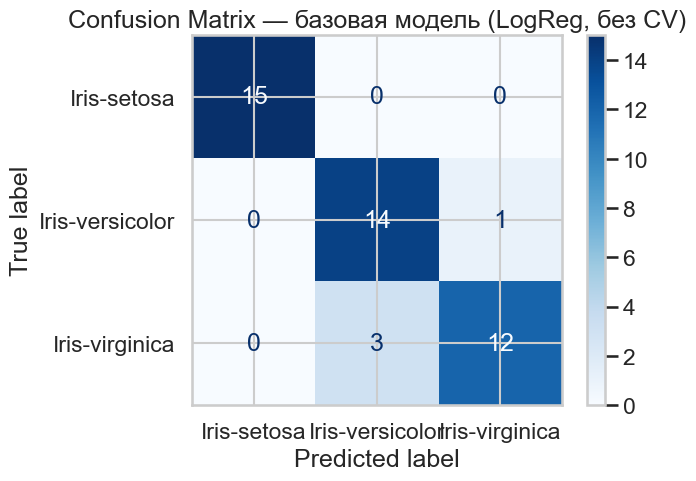

In [26]:
# -----------------------------
# ШАГ 4. Визуальный контроль: матрица ошибок (confusion matrix)
# -----------------------------
# Показывает, какие классы модель путает между собой.
ConfusionMatrixDisplay.from_predictions(target_test, test_predictions, cmap="Blues")
plt.title("Confusion Matrix — базовая модель (LogReg, без CV)")
plt.show()



# Дополнительный эксперимент: kNN (k-ближайших соседей) (k=1)

Мы заменим модель логистической регрессии на kNN и сравним результаты.


=== РЕЗУЛЬТАТЫ KNN ===
Accuracy (test): 0.933
F1-macro (test): 0.933

Отчёт по классам (classification_report):

                 precision    recall  f1-score   support

    Iris-setosa      1.000     1.000     1.000        15
Iris-versicolor      0.833     1.000     0.909        15
 Iris-virginica      1.000     0.800     0.889        15

       accuracy                          0.933        45
      macro avg      0.944     0.933     0.933        45
   weighted avg      0.944     0.933     0.933        45



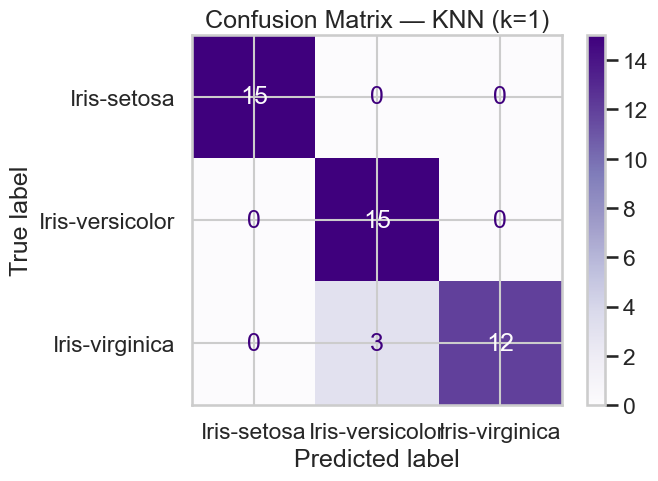

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# k=1
des_tree_model = KNeighborsClassifier(n_neighbors=1)

# Собираем тот же пайплайн (препроцессинг остаётся прежним)
des_tree_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", des_tree_model)
    ]
)

# Обучаем на train, проверяем на test
des_tree_pipeline.fit(features_train, target_train)
des_tree_predictions = des_tree_pipeline.predict(features_test)

# Метрики
des_tree_accuracy = accuracy_score(target_test, des_tree_predictions)
des_tree_f1_macro = f1_score(target_test, des_tree_predictions, average="macro")

print("\n=== РЕЗУЛЬТАТЫ KNN ===")
print("Accuracy (test):", round(des_tree_accuracy, 3))
print("F1-macro (test):", round(des_tree_f1_macro, 3))
print("\nОтчёт по классам (classification_report):\n")
print(classification_report(target_test, des_tree_predictions, digits=3))

# Матрица ошибок
ConfusionMatrixDisplay.from_predictions(target_test, des_tree_predictions, cmap="Purples")
plt.title("Confusion Matrix — KNN (k=1)")
plt.show()


## Вывод по модели KNN (k=1)
#### Общие результаты:
Accuracy: 0.933 — модель правильно предсказывает класс в 93.3% случаев.
F1-macro: 0.933 — средний F1 по классам, что близко к accuracy, так как классы сбалансированы.
#### Анализ по классам:
##### Iris-setosa:
Precision: 1.000, Recall: 1.000, F1: 1.000
Класс предсказывается идеально, без ошибок.
##### Iris-versicolor:
Precision: 0.833, Recall: 1.000, F1: 0.909
Все истинные versicolor распознаются (recall 1.000), но часть предсказаний versicolor — это на самом деле virginica (precision 0.833). По confusion matrix: 3 объекта virginica ошибочно предсказаны как versicolor.
##### Iris-virginica:
Precision: 1.000, Recall: 0.800, F1: 0.889
Когда модель предсказывает virginica, это всегда верно (precision 1.000), но 3 истинных virginica пропущены (recall 0.800).
#### Основные ошибки:
Путаница между versicolor и virginica: 3 объекта virginica ошибочно предсказаны как versicolor.
Setosa распознается идеально.
#### Сравнение с логистической регрессией:
KNN показывает немного лучший результат: 0.933 против 0.911 у логистической регрессии.
У KNN выше precision для virginica (1.000 против 0.923), но ниже recall (0.800 против 0.800).
Обе модели путают versicolor и virginica, что типично для этого датасета.
#### Заключение:
KNN (k=1) показывает хорошее качество (93.3% accuracy) на датасете Iris и немного превосходит логистическую регрессию. Setosa распознается идеально; основная путаница — между versicolor и virginica. Модель подходит для задачи классификации ирисов и может быть использована как альтернатива логистической регрессии.

# Дополнительный эксперимент: kNN (k-ближайших соседей) (k=5)

Мы заменим модель логистической регрессии на kNN и сравним результаты.


=== РЕЗУЛЬТАТЫ KNN ===
Accuracy (test): 0.911
F1-macro (test): 0.91

Отчёт по классам (classification_report):

                 precision    recall  f1-score   support

    Iris-setosa      1.000     1.000     1.000        15
Iris-versicolor      0.789     1.000     0.882        15
 Iris-virginica      1.000     0.733     0.846        15

       accuracy                          0.911        45
      macro avg      0.930     0.911     0.910        45
   weighted avg      0.930     0.911     0.910        45



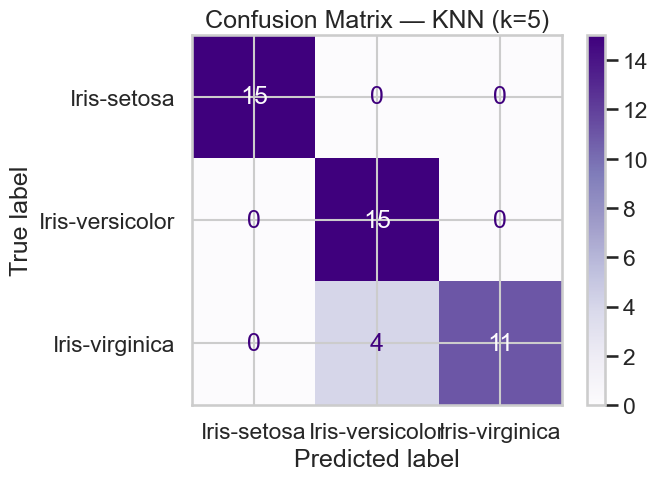

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# k=5
des_tree_model = KNeighborsClassifier(n_neighbors=5)

# Собираем тот же пайплайн (препроцессинг остаётся прежним)
des_tree_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", des_tree_model)
    ]
)

# Обучаем на train, проверяем на test
des_tree_pipeline.fit(features_train, target_train)
des_tree_predictions = des_tree_pipeline.predict(features_test)

# Метрики
des_tree_accuracy = accuracy_score(target_test, des_tree_predictions)
des_tree_f1_macro = f1_score(target_test, des_tree_predictions, average="macro")

print("\n=== РЕЗУЛЬТАТЫ KNN ===")
print("Accuracy (test):", round(des_tree_accuracy, 3))
print("F1-macro (test):", round(des_tree_f1_macro, 3))
print("\nОтчёт по классам (classification_report):\n")
print(classification_report(target_test, des_tree_predictions, digits=3))

# Матрица ошибок
ConfusionMatrixDisplay.from_predictions(target_test, des_tree_predictions, cmap="Purples")
plt.title("Confusion Matrix — KNN (k=5)")
plt.show()


## Вывод по модели KNN (k=5)
#### Общие результаты:
Accuracy: 0.911 — модель правильно предсказывает класс в 91.1% случаев.
F1-macro: 0.91 — средний F1 по классам, что близко к accuracy, так как классы сбалансированы.
#### Анализ по классам:
##### Iris-setosa:
Precision: 1.000, Recall: 1.000, F1: 1.000
Класс предсказывается идеально, без ошибок.
##### Iris-versicolor:
Precision: 0.789, Recall: 1.000, F1: 0.882
Все истинные versicolor распознаются (recall 1.000), но часть предсказаний versicolor — это на самом деле virginica (precision 0.789). По confusion matrix: 4 объекта virginica ошибочно предсказаны как versicolor.
##### Iris-virginica:
Precision: 1.000, Recall: 0.733, F1: 0.846
Когда модель предсказывает virginica, это всегда верно (precision 1.000), но 4 истинных virginica пропущены (recall 0.733).
#### Основные ошибки:
Путаница между versicolor и virginica: 4 объекта virginica ошибочно предсказаны как versicolor.
Setosa распознается идеально.
#### Сравнение с k=1:
При k=5 accuracy ниже (0.911 против 0.933 при k=1).
При k=5 больше ошибок для virginica: 4 против 3 при k=1.
Precision для versicolor ниже при k=5 (0.789 против 0.833).
#### Заключение:
KNN с k=5 показывает хорошее качество (91.1% accuracy) на датасете Iris, но немного хуже, чем при k=1. Setosa распознается идеально; основная путаница — между versicolor и virginica. Увеличение k до 5 не улучшило результат, возможно, из-за небольшого размера датасета. Для этого датасета k=1 может быть предпочтительнее.

# Дополнительный эксперимент: дерево  (max_depth=5)


=== РЕЗУЛЬТАТЫ DECISION TREE (max_depth=5) ===
Accuracy (test): 0.889
F1-macro (test): 0.889

Отчёт по классам (classification_report):

                 precision    recall  f1-score   support

    Iris-setosa      1.000     1.000     1.000        15
Iris-versicolor      0.857     0.800     0.828        15
 Iris-virginica      0.812     0.867     0.839        15

       accuracy                          0.889        45
      macro avg      0.890     0.889     0.889        45
   weighted avg      0.890     0.889     0.889        45



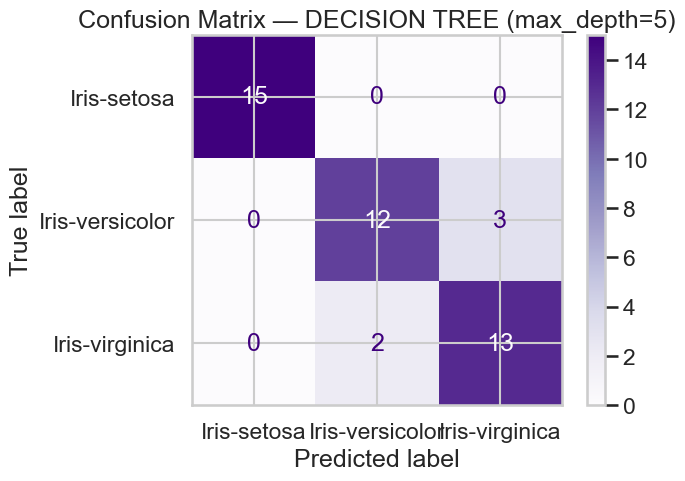

In [43]:
from sklearn.tree import DecisionTreeClassifier

des_tree = DecisionTreeClassifier(max_depth=5)

# Собираем тот же пайплайн (препроцессинг остаётся прежним)
des_tree_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", des_tree)
    ]
)

# Обучаем на train, проверяем на test
des_tree_pipeline.fit(features_train, target_train)
des_tree_predictions = des_tree_pipeline.predict(features_test)

# Метрики
des_tree_accuracy = accuracy_score(target_test, des_tree_predictions)
des_tree_f1_macro = f1_score(target_test, des_tree_predictions, average="macro")

print("\n=== РЕЗУЛЬТАТЫ DECISION TREE (max_depth=5) ===")
print("Accuracy (test):", round(des_tree_accuracy, 3))
print("F1-macro (test):", round(des_tree_f1_macro, 3))
print("\nОтчёт по классам (classification_report):\n")
print(classification_report(target_test, des_tree_predictions, digits=3))

# Матрица ошибок
ConfusionMatrixDisplay.from_predictions(target_test, des_tree_predictions, cmap="Purples")
plt.title("Confusion Matrix — DECISION TREE (max_depth=5)")
plt.show()


# Вывод по модели Decision Tree (max_depth=5)
#### Общие результаты:
Accuracy: 0.889 — модель правильно предсказывает класс в 88.9% случаев.
F1-macro: 0.889 — средний F1 по классам, что близко к accuracy, так как классы сбалансированы.
#### Анализ по классам:
##### Iris-setosa:
Precision: 1.000, Recall: 1.000, F1: 1.000
Класс предсказывается идеально, без ошибок.
##### Iris-versicolor:
Precision: 0.857, Recall: 0.800, F1: 0.828
12 из 15 объектов верно предсказаны. 3 объекта ошибочно предсказаны как virginica (по confusion matrix). Precision выше recall, значит среди предсказаний versicolor больше верных, но часть истинных versicolor пропущена.
##### Iris-virginica:
Precision: 0.812, Recall: 0.867, F1: 0.839
13 из 15 объектов верно предсказаны. 2 объекта ошибочно предсказаны как versicolor (по confusion matrix). Recall выше precision, значит большинство истинных virginica распознаются, но часть предсказаний virginica — это на самом деле versicolor.
#### Основные ошибки:
Взаимная путаница между versicolor и virginica: 3 объекта versicolor ошибочно предсказаны как virginica, и 2 объекта virginica ошибочно предсказаны как versicolor.
Setosa распознается идеально.
#### Сравнение с предыдущими моделями:
Decision Tree показывает немного ниже результат, чем логистическая регрессия (0.889 против 0.911) и KNN с k=5 (0.889 против 0.911).
Ошибки распределены между versicolor и virginica в обе стороны, в отличие от KNN, где ошибки были преимущественно в одну сторону.
#### Заключение:
Decision Tree с max_depth=5 показывает хорошее качество (88.9% accuracy) на датасете Iris, но немного уступает логистической регрессии и KNN. Setosa распознается идеально; основная путаница — между versicolor и virginica, причем ошибки идут в обе стороны. Модель подходит для задачи классификации ирисов, но для этого датасета логистическая регрессия или KNN могут быть предпочтительнее.

# Дополнительный эксперимент: дерево  (max_depth=10)


=== РЕЗУЛЬТАТЫ DECISION TREE (max_depth=10) ===
Accuracy (test): 0.956
F1-macro (test): 0.956

Отчёт по классам (classification_report):

                 precision    recall  f1-score   support

    Iris-setosa      1.000     1.000     1.000        15
Iris-versicolor      0.933     0.933     0.933        15
 Iris-virginica      0.933     0.933     0.933        15

       accuracy                          0.956        45
      macro avg      0.956     0.956     0.956        45
   weighted avg      0.956     0.956     0.956        45



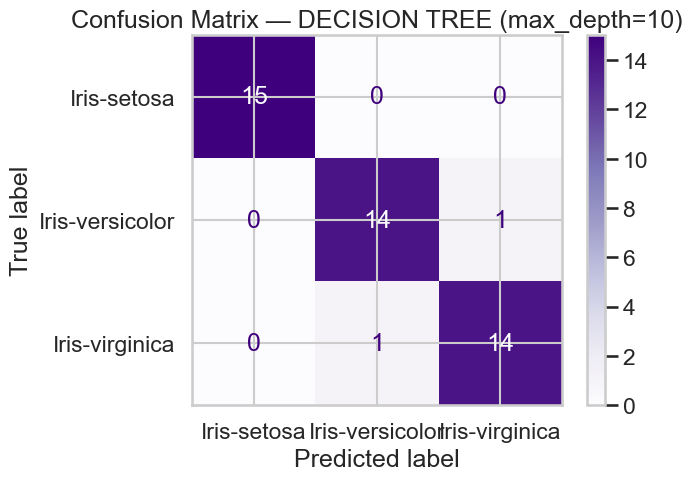

In [45]:
from sklearn.tree import DecisionTreeClassifier

des_tree = DecisionTreeClassifier(max_depth=10)

# Собираем тот же пайплайн (препроцессинг остаётся прежним)
des_tree_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", des_tree)
    ]
)

# Обучаем на train, проверяем на test
des_tree_pipeline.fit(features_train, target_train)
des_tree_predictions = des_tree_pipeline.predict(features_test)

# Метрики
des_tree_accuracy = accuracy_score(target_test, des_tree_predictions)
des_tree_f1_macro = f1_score(target_test, des_tree_predictions, average="macro")

print("\n=== РЕЗУЛЬТАТЫ DECISION TREE (max_depth=10) ===")
print("Accuracy (test):", round(des_tree_accuracy, 3))
print("F1-macro (test):", round(des_tree_f1_macro, 3))
print("\nОтчёт по классам (classification_report):\n")
print(classification_report(target_test, des_tree_predictions, digits=3))

# Матрица ошибок
ConfusionMatrixDisplay.from_predictions(target_test, des_tree_predictions, cmap="Purples")
plt.title("Confusion Matrix — DECISION TREE (max_depth=10)")
plt.show()


## Вывод по модели Decision Tree (max_depth=10)
#### Общие результаты:
Accuracy: 0.956 — модель правильно предсказывает класс в 95.6% случаев.
F1-macro: 0.956 — средний F1 по классам, что близко к accuracy, так как классы сбалансированы.
#### Анализ по классам:
##### Iris-setosa:
Precision: 1.000, Recall: 1.000, F1: 1.000
Класс предсказывается идеально, без ошибок.
##### Iris-versicolor:
Precision: 0.933, Recall: 0.933, F1: 0.933
14 из 15 объектов верно предсказаны. 1 объект ошибочно предсказан как virginica (по confusion matrix). Метрики сбалансированы.
##### Iris-virginica:
Precision: 0.933, Recall: 0.933, F1: 0.933
14 из 15 объектов верно предсказаны. 1 объект ошибочно предсказан как versicolor (по confusion matrix). Метрики сбалансированы.
#### Основные ошибки:
Взаимная путаница между versicolor и virginica: по 1 ошибке в каждую сторону.
Setosa распознается идеально.
Сравнение с max_depth=5:
Увеличение глубины до 10 улучшило результат: 0.956 против 0.889 при max_depth=5.
Ошибок меньше: 2 против 5 при max_depth=5.
Метрики по versicolor и virginica стали сбалансированными (precision = recall).
#### Сравнение с другими моделями:
Decision Tree с max_depth=10 показывает лучший результат среди всех протестированных моделей: 0.956 против 0.911 у логистической регрессии и KNN с k=5, и 0.933 у KNN с k=1.
#### Заключение:
Decision Tree с max_depth=10 показывает наилучшее качество (95.6% accuracy) на датасете Iris среди всех протестированных моделей. Setosa распознается идеально; путаница между versicolor и virginica минимальна (по 1 ошибке в каждую сторону). Увеличение глубины дерева с 5 до 10 значительно улучшило качество модели, что говорит о том, что для этого датасета более глубокая модель лучше улавливает закономерности.

# Дополнительный эксперимент: случайный лес (DEFAULT)


=== РЕЗУЛЬТАТЫ RANDOM FOREST TREE DEFAULT ===
Accuracy (test): 0.889
F1-macro (test): 0.888

Отчёт по классам (classification_report):

                 precision    recall  f1-score   support

    Iris-setosa      1.000     1.000     1.000        15
Iris-versicolor      0.778     0.933     0.848        15
 Iris-virginica      0.917     0.733     0.815        15

       accuracy                          0.889        45
      macro avg      0.898     0.889     0.888        45
   weighted avg      0.898     0.889     0.888        45



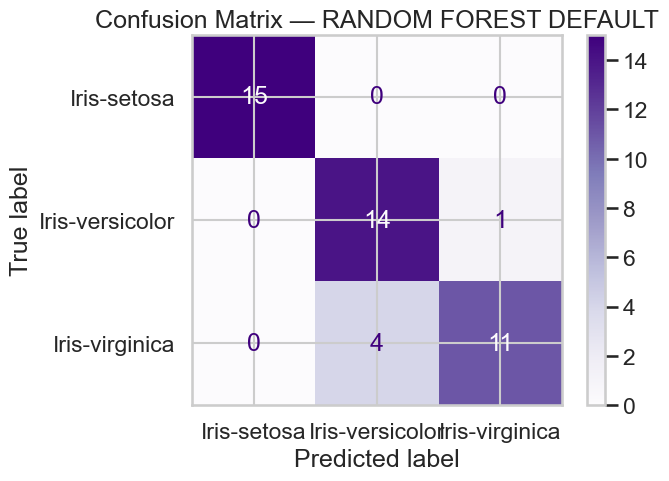

In [57]:
from sklearn.ensemble import RandomForestClassifier

rnd_for = RandomForestClassifier()

# Собираем тот же пайплайн (препроцессинг остаётся прежним)
rnd_for_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", rnd_for)
    ]
)

# Обучаем на train, проверяем на test
rnd_for_pipeline.fit(features_train, target_train)
rnd_for_predictions = rnd_for_pipeline.predict(features_test)

# Метрики
rnd_for_accuracy = accuracy_score(target_test, rnd_for_predictions)
rnd_for_f1_macro = f1_score(target_test, rnd_for_predictions, average="macro")

print("\n=== РЕЗУЛЬТАТЫ RANDOM FOREST TREE DEFAULT ===")
print("Accuracy (test):", round(rnd_for_accuracy, 3))
print("F1-macro (test):", round(rnd_for_f1_macro, 3))
print("\nОтчёт по классам (classification_report):\n")
print(classification_report(target_test, rnd_for_predictions, digits=3))

# Матрица ошибок
ConfusionMatrixDisplay.from_predictions(target_test, rnd_for_predictions, cmap="Purples")
plt.title("Confusion Matrix — RANDOM FOREST DEFAULT")
plt.show()


## Вывод по модели Random Forest (default)
#### Общие результаты:
Accuracy: 0.889 — модель правильно предсказывает класс в 88.9% случаев.
F1-macro: 0.888 — средний F1 по классам, что близко к accuracy, так как классы сбалансированы.
#### Анализ по классам:
##### Iris-setosa:
Precision: 1.000, Recall: 1.000, F1: 1.000
Класс предсказывается идеально, без ошибок.
##### Iris-versicolor:
Precision: 0.778, Recall: 0.933, F1: 0.848
14 из 15 объектов верно предсказаны. 1 объект ошибочно предсказан как virginica (по confusion matrix). Recall выше precision: большинство истинных versicolor распознаются, но среди предсказаний versicolor есть ошибки.
##### Iris-virginica:
Precision: 0.917, Recall: 0.733, F1: 0.815
14 из 15 объектов верно предсказаны. 1 объект ошибочно предсказан как versicolor (по confusion matrix). Precision выше recall: когда модель предсказывает virginica, это обычно верно, но часть истинных virginica пропущена.
#### Основные ошибки:
Взаимная путаница между versicolor и virginica: по 1 ошибке в каждую сторону.
Setosa распознается идеально.
#### Сравнение с другими моделями:
Random Forest показывает такой же результат, как Decision Tree с max_depth=5: 0.889 accuracy.
Результат ниже, чем у Decision Tree с max_depth=10 (0.889 против 0.956).
Ошибок меньше, чем у Decision Tree с max_depth=5 (2 против 5), но больше, чем у Decision Tree с max_depth=10 (2 против 2).
#### Заключение:
Random Forest с параметрами по умолчанию показывает хорошее качество (88.9% accuracy) на датасете Iris, сопоставимое с Decision Tree при max_depth=5. Setosa распознается идеально; путаница между versicolor и virginica минимальна (по 1 ошибке в каждую сторону). Для этого датасета Random Forest с параметрами по умолчанию работает хорошо, но уступает Decision Tree с max_depth=10. Возможно, настройка гиперпараметров (например, увеличение количества деревьев или глубины) улучшит результат

# Дополнительный эксперимент: SVM (DEFAULT)


=== РЕЗУЛЬТАТЫ SVM DEFAULT ===
Accuracy (test): 0.933
F1-macro (test): 0.933

Отчёт по классам (classification_report):

                 precision    recall  f1-score   support

    Iris-setosa      1.000     1.000     1.000        15
Iris-versicolor      0.875     0.933     0.903        15
 Iris-virginica      0.929     0.867     0.897        15

       accuracy                          0.933        45
      macro avg      0.935     0.933     0.933        45
   weighted avg      0.935     0.933     0.933        45



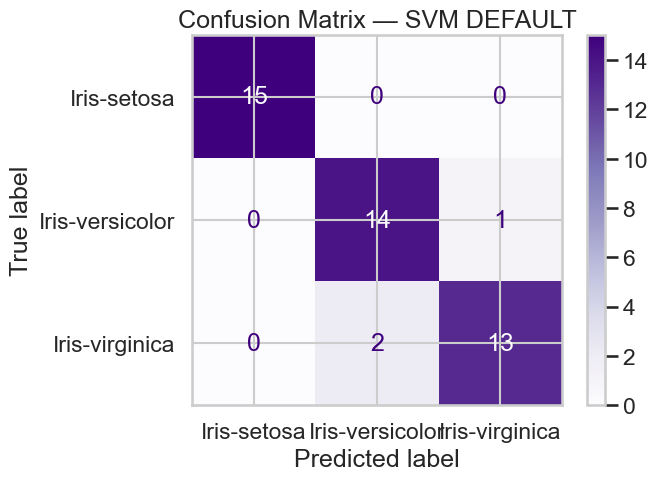

In [62]:
from sklearn.svm import SVC

svm = SVC()

# Собираем тот же пайплайн (препроцессинг остаётся прежним)
svm_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", svm)
    ]
)

# Обучаем на train, проверяем на test
svm_pipeline.fit(features_train, target_train)
svm_predictions = svm_pipeline.predict(features_test)

# Метрики
svm_accuracy = accuracy_score(target_test, svm_predictions)
svm_f1_macro = f1_score(target_test, svm_predictions, average="macro")

print("\n=== РЕЗУЛЬТАТЫ SVM DEFAULT ===")
print("Accuracy (test):", round(svm_accuracy, 3))
print("F1-macro (test):", round(svm_f1_macro, 3))
print("\nОтчёт по классам (classification_report):\n")
print(classification_report(target_test, svm_predictions, digits=3))

# Матрица ошибок
ConfusionMatrixDisplay.from_predictions(target_test, svm_predictions, cmap="Purples")
plt.title("Confusion Matrix — SVM DEFAULT")
plt.show()


## Вывод по модели SVM (default)
#### Общие результаты:
Accuracy: 0.933 — модель правильно предсказывает класс в 93.3% случаев.
F1-macro: 0.933 — средний F1 по классам, что близко к accuracy, так как классы сбалансированы.
#### Анализ по классам:
##### Iris-setosa:
Precision: 1.000, Recall: 1.000, F1: 1.000
Класс предсказывается идеально, без ошибок.
##### Iris-versicolor:
Precision: 0.875, Recall: 0.933, F1: 0.903
14 из 15 объектов верно предсказаны. 1 объект ошибочно предсказан как virginica (по confusion matrix). Recall выше precision: большинство истинных versicolor распознаются, но среди предсказаний versicolor есть ошибки.
##### Iris-virginica:
Precision: 0.929, Recall: 0.867, F1: 0.897
13 из 15 объектов верно предсказаны. 2 объекта ошибочно предсказаны как versicolor (по confusion matrix). Precision выше recall: когда модель предсказывает virginica, это обычно верно, но часть истинных virginica пропущена.
#### Основные ошибки:
Путаница между versicolor и virginica: 1 объект versicolor ошибочно предсказан как virginica, и 2 объекта virginica ошибочно предсказаны как versicolor.
Setosa распознается идеально.
#### Сравнение с другими моделями:
SVM показывает хороший результат: 0.933 accuracy, что равно результату KNN с k=1 и выше, чем у логистической регрессии (0.911), KNN с k=5 (0.911), Decision Tree с max_depth=5 (0.889) и Random Forest (0.889).
Результат ниже, чем у Decision Tree с max_depth=10 (0.933 против 0.956).
#### Заключение:
SVM с параметрами по умолчанию показывает хорошее качество (93.3% accuracy) на датасете Iris, сопоставимое с лучшими результатами других моделей. Setosa распознается идеально; основная путаница — между versicolor и virginica, что типично для этого датасета. Модель подходит для задачи классификации ирисов и может быть использована как альтернатива другим алгоритмам. Для дальнейшего улучшения можно попробовать разные ядра (linear, rbf, poly) или настроить гиперпараметры.

## Общий вывод по всем моделям

**Сравнительная таблица результатов:**

| Модель | Accuracy | F1-macro | Примечания |
|--------|----------|----------|------------|
| **Decision Tree (max_depth=10)** | **0.956** | **0.956** | Лучший результат |
| KNN (k=1) | 0.933 | 0.933 | Хороший результат |
| SVM (default) | 0.933 | 0.933 | Хороший результат |
| Логистическая регрессия | 0.911 | 0.911 | Базовый результат |
| KNN (k=5) | 0.911 | 0.910 | Хуже, чем k=1 |
| Decision Tree (max_depth=5) | 0.889 | 0.889 | Недостаточная глубина |
| Random Forest (default) | 0.889 | 0.888 | Требует настройки |

**Основные наблюдения:**

1. **Лучшая модель:** Decision Tree с max_depth=10 показала наилучший результат (95.6% accuracy). Увеличение глубины с 5 до 10 значительно улучшило качество модели.

2. **Iris-setosa:** Все модели распознают этот класс идеально (precision и recall = 1.000), что указывает на его хорошую отделимость от других классов.

3. **Основная проблема:** Все модели путают Iris-versicolor и Iris-virginica, что типично для датасета Iris из-за схожести признаков между этими классами.

4. **Влияние гиперпараметров:**
   - **KNN:** k=1 показал лучший результат, чем k=5 для этого датасета.
   - **Decision Tree:** Увеличение max_depth с 5 до 10 значительно улучшило результат.

5. **Простые vs сложные модели:**
   - Логистическая регрессия показала стабильный и хороший результат (0.911).
   - KNN и SVM показали сопоставимые результаты (0.933).
   - Random Forest с параметрами по умолчанию не превзошел простые модели.

**Рекомендации:**

1. Для датасета Iris **Decision Tree с max_depth=10** является оптимальным выбором.
2. Если важна интерпретируемость, логистическая регрессия дает хороший баланс между простотой и качеством.
3. KNN (k=1) и SVM являются хорошими альтернативами с близким качеством.
4. Random Forest требует настройки гиперпараметров для улучшения результата.

**Заключение:**

Все протестированные модели показали хорошие результаты (accuracy от 88.9% до 95.6%) на датасете Iris. Лучший результат показала Decision Tree с max_depth=10. Основная сложность для всех моделей — различение versicolor и virginica, что характерно для этого датасета, поскольку есть пересечение признаков между этими классами. Для практического применения можно выбрать Decision Tree с max_depth=10 или одну из моделей с accuracy около 0.933 (KNN k=1 или SVM), в зависимости от требований к интерпретируемости и скорости работы.

# Кросс-валидация дерево с max_depth=5 и max_depth=10 по 5 фолдам


In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import numpy as np

dt5_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(max_depth=5))
])

dt10_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(max_depth=10))
])

print("=" * 60)
print("КРОСС-ВАЛИДАЦИЯ DECISION TREE")
print("=" * 60)

cv_scores_acc_5 = cross_val_score(dt5_pipeline, features_train, target_train, cv=5, scoring='accuracy')
cv_scores_f1_5 = cross_val_score(dt5_pipeline, features_train, target_train, cv=5, scoring='f1_macro')

print("\n--- Decision Tree (max_depth=5) ---")
print(f"Accuracy: {cv_scores_acc_5.mean():.3f} (+/- {cv_scores_acc_5.std() * 2:.3f})")
print(f"F1-macro: {cv_scores_f1_5.mean():.3f} (+/- {cv_scores_f1_5.std() * 2:.3f})")
print(f"Детальные результаты по фолдам (Accuracy): {cv_scores_acc_5}")

cv_scores_acc_10 = cross_val_score(dt10_pipeline, features_train, target_train, cv=5, scoring='accuracy')
cv_scores_f1_10 = cross_val_score(dt10_pipeline, features_train, target_train, cv=5, scoring='f1_macro')

print("\n--- Decision Tree (max_depth=10) ---")
print(f"Accuracy: {cv_scores_acc_10.mean():.3f} (+/- {cv_scores_acc_10.std() * 2:.3f})")
print(f"F1-macro: {cv_scores_f1_10.mean():.3f} (+/- {cv_scores_f1_10.std() * 2:.3f})")
print(f"Детальные результаты по фолдам (Accuracy): {cv_scores_acc_10}")

# Сравнение
print("\n--- Сравнение ---")
print(f"Разница в Accuracy: {cv_scores_acc_10.mean() - cv_scores_acc_5.mean():.3f}")
print(f"Разница в F1-macro: {cv_scores_f1_10.mean() - cv_scores_f1_5.mean():.3f}")

КРОСС-ВАЛИДАЦИЯ DECISION TREE

--- Decision Tree (max_depth=5) ---
Accuracy: 0.943 (+/- 0.038)
F1-macro: 0.952 (+/- 0.060)
Детальные результаты по фолдам (Accuracy): [0.95238095 0.95238095 0.95238095 0.9047619  0.95238095]

--- Decision Tree (max_depth=10) ---
Accuracy: 0.952 (+/- 0.060)
F1-macro: 0.943 (+/- 0.038)
Детальные результаты по фолдам (Accuracy): [0.95238095 0.95238095 1.         0.9047619  0.95238095]

--- Сравнение ---
Разница в Accuracy: 0.010
Разница в F1-macro: -0.010


## Вывод по кросс-валидации Decision Tree

**Наблюдение:**
На тестовой выборке Decision Tree с max_depth=10 показал значительно лучший результат (0.956), чем с max_depth=5 (0.889). Однако при кросс-валидации разница минимальна:
- max_depth=5: Accuracy 0.943 (+/- 0.038)
- max_depth=10: Accuracy 0.952 (+/- 0.060)

Скорее всего это связано с тем, что в датасете Iris мало данных, классы достаточно разделимы, и глубокие деревья не дают существенного преимущества, особенно при разбиении на 5 фолдов.

**Вывод:**
Однако в любом случае кросс-валидация дает более надежную оценку качества модели, чем одно разбиение на train/test. Для датасета Iris Decision Tree с max_depth=5 и max_depth=10 показывают сопоставимые результаты при кросс-валидации, поэтому можно выбрать более простую модель (max_depth=5) для лучшей интерпретируемости и меньшего риска переобучения.